# Pipeline Notebook

The Notebook implements the logic to:
    
  * undistort
  * binary
  * ...

an input image.

A pipeline is defined and tested on static images and on 2 videos.

## Pipeline (single image)

In [2]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_ubyte
%matplotlib inline

### Helper functions

In [3]:
def display_save_images(images, titles=None, fname=None):
    """ Displays the input images in a subplot.
        After the images have been displayed, this
        function saves them in the 'output_images'
        directory.
        
    Parameter:
        - images: a list of images.
        - titles: a list of titles.
    """
    img_count = len(images)
    m_cols = 2
    m_rows = int(img_count/m_cols) + (int(img_count/m_cols)==0)

    plt.figure(figsize=(3*m_cols, 2*m_rows))
    for idx in range(img_count):
        plt.subplot(m_rows, m_cols, idx+1)

        if titles is not None:
            plt.title(titles[idx])

        plt.axis('off')

        if len(images[idx].shape)==3:
            plt.imshow(images[idx])
        else:
            plt.imshow(images[idx], cmap='binary')

    plt.tight_layout(pad=0.50)

    if fname is not None:
        plt.savefig('../output_images/' + fname + '.jpg')

    plt.show()
    return

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Load Camera Calibration Parameters

In [4]:
def load_camera_cal_params(pickle_fname):
    """ Loads from a pickle file the camera
        distortion matrix and distances.

    Parameter:
        - pickle_fname: Pickle file name.
    Returns:
        - (mtx, dist) tuple.
    """
    with open(pickle_fname, "rb") as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']

pickle_fname = '../output_images/camera_cal_mtx_dist.p'
mtx, dist = load_camera_cal_params(pickle_fname)

In [5]:
assert mtx is not None
assert mtx.shape == (3,3)
assert dist is not None

### Undistortion

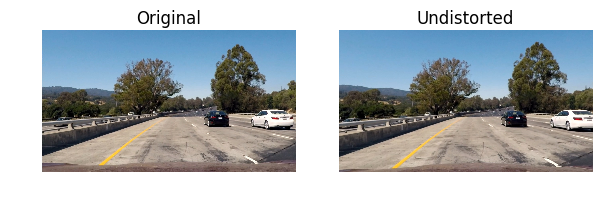

In [6]:
def pipeline_undistort(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

#img_fname = '../test_images/straight_lines2.jpg'
img_fname = '../test_images/test1.jpg'
img = mpimg.imread(img_fname)
img_undist = pipeline_undistort(img, mtx, dist)
display_save_images([img, img_undist], ['Original', 'Undistorted'], 'undistorted_road')

### Create a Binary Image

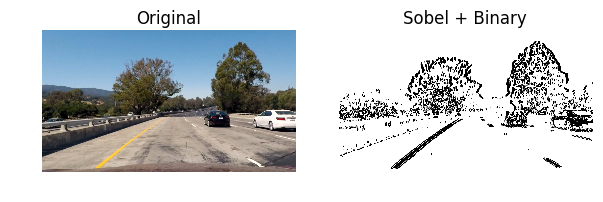

In [7]:
def binary_transform(img, sobel_kernel=3, sc_thresh=(170, 255), sx_thresh=(20, 100)):
    """ Given an input image it convert the image color space
        from RGB to HLS, tekes only the S channel and applies
        Sobel thresholding along X axis.

        Returns: a color binary image with only those pixels
        set to 1 iff the Sobel values were within the sx_thresh
        and the S channel values were within the sc_thresh.
    """
    
    img = np.copy(img)

    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Use the s_channel
    channel = s_channel
    
    # Sobel x and y
    sobel_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Absolute derivative in x and y
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel_x = np.uint8(255*sobel_x_abs/np.max(sobel_x_abs))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= sx_thresh[0]) & (scaled_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(channel >= sc_thresh[0]) & (channel <= sc_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary))

    # Create a binary flat image.
    flat_binary = np.zeros_like(sx_binary)
    flat_binary[(sx_binary == 1) | (s_binary == 1)] = 1

    return flat_binary


ksize     = 31
d_thresh  = (0.7, 1.2)
sx_thresh = (20, 100)
sc_thresh = (170, 255)

result = binary_transform(img_undist,
                          sobel_kernel=ksize,
                          sc_thresh=sc_thresh,
                          sx_thresh=sx_thresh )
display_save_images([img_undist, result], ['Original', 'Sobel + Binary'], 'binary_transform')

### Apply Perspective Transformation (Bird's eye)

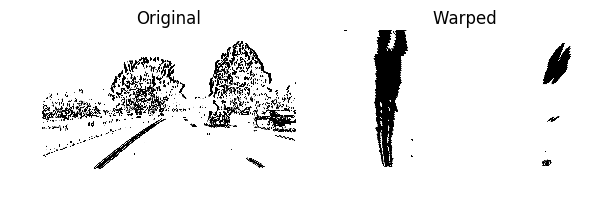

In [8]:
def birds_eye_view(img):
    """ Apply perspective transformation on input image.
        Returns: The transformed input image (Bird's Eye) as uint8 type.
    """
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M

warped, M = birds_eye_view(result)
display_save_images([result, warped], ['Original', 'Warped'], 'warped')

### Display Lines Histogram

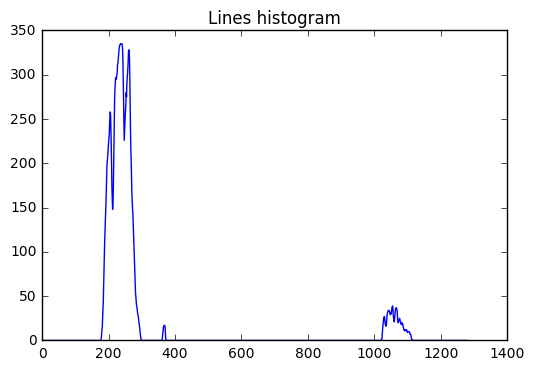

In [9]:
def display_histogram(img):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    plt.title('Lines histogram')
    plt.plot(histogram)
    plt.savefig('../output_images/histogram.jpg')
    return

display_histogram(warped)

### Find Lines and Compute Curve Radius

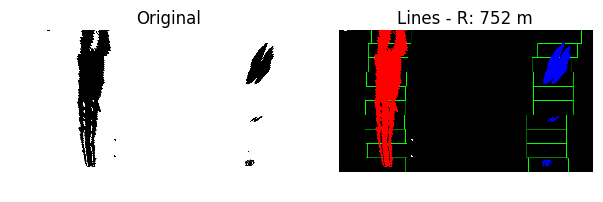

In [10]:
def fit_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ########################
    #### Display result ####
    ########################
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #out_img[ploty.astype(np.int32), left_fitx.astype(np.int32)] = [255, 255, 0]
    #out_img[ploty.astype(np.int32), right_fitx.astype(np.int32)] = [255, 255, 0]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad,right_curverad])
    return out_img, avg_radius_meters, left_fitx, right_fitx, ploty

img_lines, r_meters, l_fit, r_fit, ploty = fit_lines(warped)
display_save_images([warped, img_lines], ['Original', 'Lines - R: {:.0f} m'.format(r_meters)], 'lines')

### Compute Car Position

### Back to original image perspective

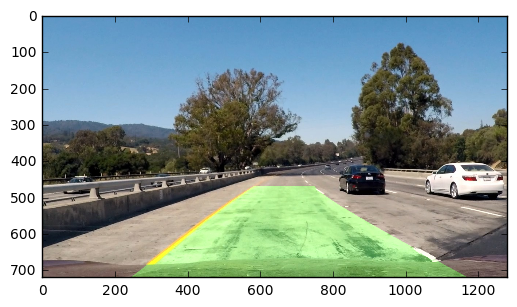

In [11]:
def to_real_world_space(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

Minv = np.linalg.inv(M)
final_output = to_real_world_space(img, img_lines, Minv, l_fit, r_fit, ploty)
plt.imshow(final_output)
plt.show()

## Prepare Pipeline

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

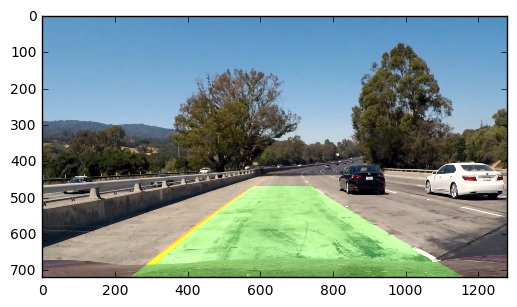

In [13]:
def process_image(img):
    # NOTE: The output you return should be a color
    # image (3 channel) for processing video below
    # Your pipeline here, return the final
    # output (image with lines are drawn on lanes)
    ksize     = 9
    d_thresh  = (0.7, 1.2)
    sx_thresh = (20, 100)
    sc_thresh = (170, 255)

    img_undist = pipeline_undistort(img, mtx, dist)
    binary = binary_transform(img_undist,
                              sobel_kernel=ksize,
                              sc_thresh=sc_thresh,
                              sx_thresh=sx_thresh )
    warped, M = birds_eye_view(binary)
    img_lines, r_meters, l_fit, r_fit, ploty = fit_lines(warped)

    Minv = np.linalg.inv(M)
    final_output = to_real_world_space(img, img_lines, Minv, l_fit, r_fit, ploty)
    return final_output

r = process_image(img)
plt.imshow(r)
plt.show()

## Pipeline (video 1)

In [14]:
project_video_output = '../output_video/project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../output_video/project_video.mp4
[MoviePy] Writing video ../output_video/project_video.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  4.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_video/project_video.mp4 

CPU times: user 7min 22s, sys: 1min 36s, total: 8min 58s
Wall time: 5min 28s


Play the video inline. The video is also saved in the `output_video` directory.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Pipeline (video 2 - optional)

In [ ]:
challenge_video_output = '../output_video/challenge_video.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(challenge_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

## Pipeline (video 3 - optional)

In [ ]:
harder_challenge_video_output = '../output_video/harder_challenge_video.mp4'
clip1 = VideoFileClip("../harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(harder_challenge_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))